In [1]:
from collections import OrderedDict
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import time
import scipy.io as io
import random
import os
import pickle
from sklearn.cluster import KMeans

In [4]:
field = np.zeros((100,100), dtype=np.float64)
indices = np.argwhere(field == 0)
borders = np.array([idx for idx in indices if (idx[0]==0 or idx[0]==99) or (idx[1]==0 or idx[1]==99)])

In [31]:
border_anchors = np.array([[0,0],[0,20],[0,40],[0,60],[0,80],[0,99], \
                           [99,0],[99,20],[99,40],[99,60],[99,80],[99,99], \
                           [20,0],[40,0],[60,0],[80,0], \
                           [20,99],[40,99],[60,99],[80,99]
                          ])

In [33]:
border_anchors.shape

(20, 2)

In [53]:
targets = np.array([[[50,50]],[[75,75]]])
obstacles = np.array([[0,0],[0,20],[0,40],[0,60],[0,80],[0,99], \
                           [99,0],[99,20],[99,40],[99,60],[99,80],[99,99], \
                           [20,0],[40,0],[60,0],[80,0], \
                           [20,99],[40,99],[60,99],[80,99]
                          ])

In [58]:
targets = np.array([[[50,50]],[[75,75]]])


In [69]:
arr = np.array([[50,50],[75,75]])

In [70]:
arr = arr.reshape((len(arr),1,2))

In [71]:
arr

array([[[50, 50]],

       [[75, 75]]])

In [79]:
dist_to_targets = np.linalg.norm(indices-np.array([0,0]), axis=1)

In [75]:
np.hypot(indices,np.array([0,0])).shape

(10000, 2)

In [80]:
dist_to_targets.shape

(10000,)

In [101]:
diff = (indices - targets)

In [102]:
dist = np.linalg.norm(diff, axis=2)

In [104]:
dist = np.maximum(dist,0.1)

In [106]:
(1/dist).shape

(2, 10000)

In [91]:
field = (dist < 10).astype(int)[0].reshape((100,100))

In [93]:
field[50,50]

1

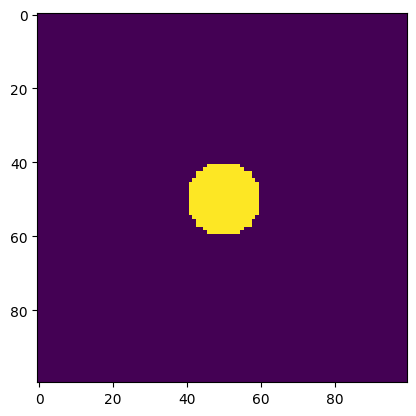

In [92]:
plt.imshow(field)

In [85]:
(dist**2).shape

(2, 10000)

In [56]:
sum_dist = np.sum(dist, axis=0)

In [51]:
sum_dist.shape

(10000,)

In [19]:
dist =  np.linalg.norm(indices-np.array([0,0]), axis=1).reshape((100,100))

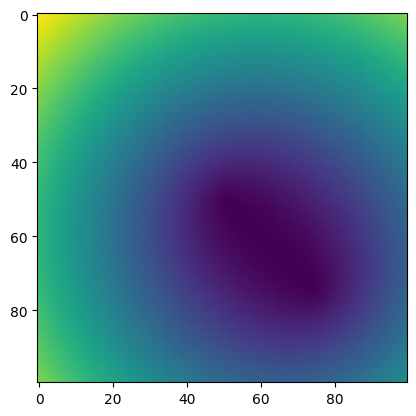

In [57]:
plt.imshow(sum_dist.reshape((100,100)))

In [11]:
field[indices[0][0]]=11

In [12]:
field

array([[11., 11., 11., ..., 11., 11., 11.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [195]:
DEFAULT_CFG = {'k_att':1, 'k_rep':1, 'd_rep': 2, 'gamma': 0}
class PotentialFields():
    def __init__(self, size=100, targets=[], obstacles=[], config=DEFAULT_CFG):
        self.field = np.zeros((size,size), dtype=np.float64)
        self.indices = np.argwhere(self.field == 0)
        self.targets = np.array(targets).reshape((len(targets),1,2))
        self.obstacles = np.array(obstacles).reshape((len(obstacles),1,2))
        self.size = size
        self.k_att = config['k_att']
        self.k_rep = config['k_rep']
        self.d_rep = config['d_rep']
        self.gamma = config['gamma']
    
    def attraction_field(self, targets, k_att):
        dist = np.linalg.norm(self.indices - targets, axis=2)
        U_att = k_att * dist**2 * 0.5
        att_field = np.mean(U_att, axis=0)
        return att_field.reshape((self.size, self.size))      
    
    def repulsion_field(self, obstacles, k_rep, d_rep):
        dist = np.linalg.norm(self.indices - obstacles, axis=2)
        dist = np.maximum(dist,0) # avoid divide by zero
        mask = (dist > d_rep).astype(float)
        U_rep = mask * (k_rep * (d_rep-dist)**2)
        # U_rep = mask * (k_rep * dist**2)
        rep_field = np.mean(U_rep, axis=0)
        return rep_field.reshape((self.size, self.size))      
    
    def get_potential_field(self):
        self.att_field = self.attraction_field(self.targets, self.k_att)
        self.rep_field = self.repulsion_field(self.obstacles, self.k_rep, self.d_rep)
        w_att, w_rep = np.maximum(0, 1+self.gamma), np.maximum(0, 1-self.gamma)
        raw_field = w_att * self.att_field + w_rep * self.rep_field
        # scaled_field = (raw_field - np.min(raw_field))/np.ptp(raw_field)
        # return scaled_field   
        return raw_field

In [2]:
DEFAULT_CFG = {'k_rep_traj':0.8, 'k_rep_border':1, 'traj_d':15, 'border_d':10, 'traj_skip':1}
class PotentialFields():
    def __init__(self, size=100, config=DEFAULT_CFG):
        self.field = np.zeros((size,size), dtype=np.float64)
        self.indices = np.argwhere(self.field == 0)
        self.borders = np.array([idx for idx in indices if (idx[0]==0 or idx[0]==99) or (idx[1]==0 or idx[1]==99)])
        self.borders = np.array(self.borders).reshape((len(self.borders),1,2))
        self.size = size
        self.k_rep_traj = config['k_rep_traj']
        self.k_rep_border = config['k_rep_border']
        self.traj_d = config['traj_d']
        self.border_d = config['border_d']
        self.traj_skip = config['traj_skip']
        # generate border repel field
        dist = np.linalg.norm(self.indices - self.borders, axis=2)
        dist = np.maximum(dist,1)
        mask = (dist <= self.border_d).astype(float)
        U_rep_border = mask * (self.k_rep_border * (self.border_d-dist)**2)
        self.raw_border_field = np.sum(U_rep_border, axis=0)
        self.scaled_border_field = (self.raw_border_field - np.min(self.raw_border_field))/np.ptp(self.raw_border_field)
        
    def get_potential_field(self, trajectory=[]):
        if len(trajectory) <= self.traj_skip:
            return self.scaled_border_field.reshape((self.size, self.size))
        else:
            traj = np.flip(trajectory,axis=1)
            traj = traj[:-self.traj_skip].reshape((len(trajectory)-self.traj_skip,1,2))
            dist = np.linalg.norm(self.indices - traj, axis=2)
            mask = (dist <= self.traj_d).astype(float)
            U_rep = mask * (self.k_rep_traj * (self.traj_d - dist)**2)
            raw_field = np.mean(U_rep, axis=0)
            scaled_field = (raw_field - np.min(raw_field))/np.ptp(raw_field)
            field = self.scaled_border_field + scaled_field
            return field.reshape((self.size, self.size))

In [7]:
traj = [[20,10],[21,11],[22,12],[23,13],[23,14],[23,15],[23,16],[23,17],[23,18],[23,19],[23,20],[23,21]]
pf = PotentialFields()
field = pf.get_potential_field(trajectory=traj)

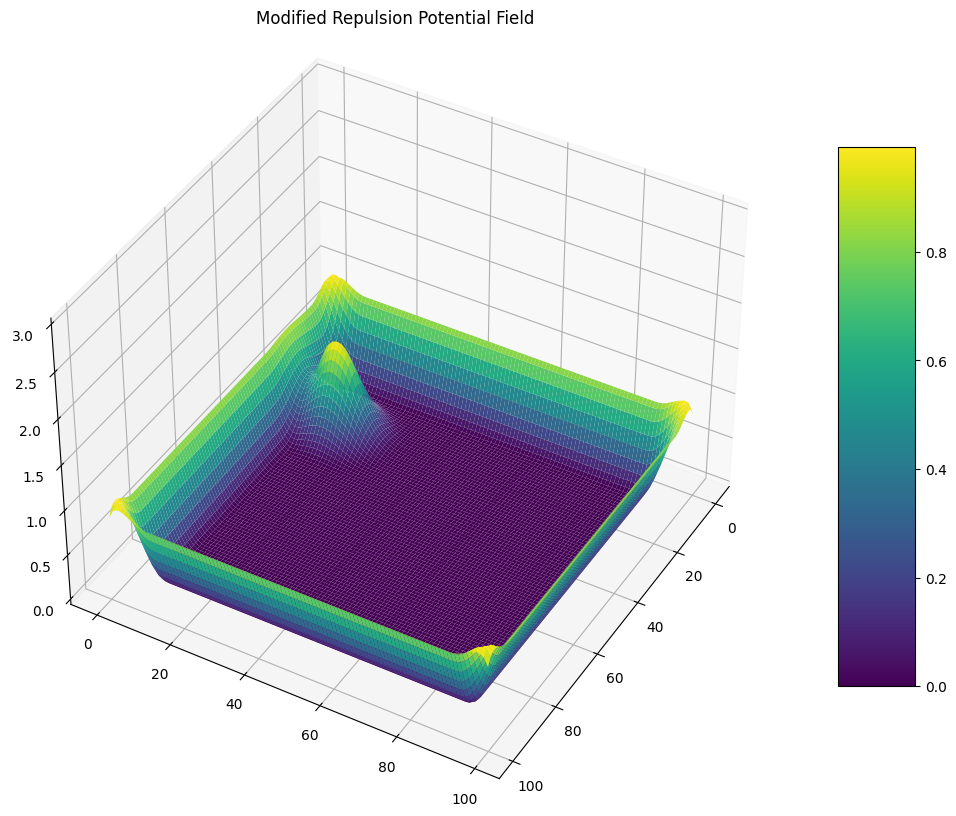

In [8]:
x = np.linspace(0, 99, 100)
y = np.linspace(0, 99, 100)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize =(15, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, field, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Modified Repulsion Potential Field')
ax.set_zlim(0, 3)
ax.view_init(elev=40, azim=30)
fig.colorbar(surf, ax = ax, shrink = 0.7, aspect = 7) 

In [348]:
from collections import OrderedDict
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import time
import scipy.io as io
import random
import os
import pickle
from sklearn.cluster import KMeans

ACTION_MAP = {0:"left",1:"right",2:"up",3:"down",4:"up-left",5:"up-right",6:"down-left",7:"down-right"}
ACTIONS = ["left", "right", "up", "down", "up-left", "up-right", "down-left", "down-right"]
ACTION_OFFSET = [[-1,0],[1,0],[0,-1],[0,1],[-1,-1],[1,-1],[-1,1],[1,1]]
DEFAULT_CFG = {'k_rep_traj':0.5, 'k_rep_border':1, 'traj_d':20, 'border_d':15}

class PotentialFieldEnv(gym.Env):
    def __init__(self, max_num_steps=200):
        metadata = {'render.modes': ['human']}
        super(PotentialFieldEnv, self).__init__()                    
        self.max_num_steps = max_num_steps
        
        # Env Field
        self.size = 100
        self.vs_hsize = 5
        self.field = np.zeros((100,100), dtype=np.uint8)
        self.indices = np.argwhere(self.field == 0)

        # Agent Field related params/variables
        self.num_steps = 0
        self.agent_position = None
        self.agent_trajectory = []
        self.potential_field = PotentialFields(size=self.size)

        # Action Space
        self.action_space_map = ACTION_MAP
        self.actions = ACTIONS
        self.action_space = spaces.Discrete(8)

        # Environment Observation space
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.size, self.size, 1), dtype=np.uint8)    
        

    def step(self, action_id):
        assert self.action_space.contains(action_id), "Action is invalid!"
        (next_position, hit_wall) = self.get_next_position(action_id)
        
        # Update number of steps
        self.num_steps += 1

        # Get any observations
        observations = {"location": next_position}

        # Update agent variables       
        self.agent_position = next_position
        self.update_agent(next_position)        
        self.agent_trajectory.append(self.agent_position)
        
        # Check for termination criteria
        done = (self.num_steps >= self.max_num_steps)
        reward = self.calculate_reward()
        
        # Record field values
        # next_state = np.expand_dims(self.field, axis=-1)
        next_state = self.get_field_image()
        return (next_state, reward, done, observations)

    def reset(self):
        # Reset agent related params
        self.num_steps = 0
        self.field = np.zeros((100,100), dtype=np.uint8)
        self.agent_position = self.choose_random_start_position()
        self.update_agent(self.agent_position)
        self.agent_trajectory = []
        return self.get_field_image()
      
    def update_agent(self, pos):
        min_x, max_x = pos[0] - self.vs_hsize, pos[0] + self.vs_hsize + 1
        min_y, max_y = pos[1] - self.vs_hsize, pos[1] + self.vs_hsize + 1        
        self.field[min_y:max_y, min_x:max_x] = 255
        # plt.imshow(self.field)
        # plt.show()

    def get_field_image(self):
        img = self.field.copy()
        min_x, max_x = self.agent_position[0] - self.vs_hsize, self.agent_position[0] + self.vs_hsize + 1
        min_y, max_y = self.agent_position[1] - self.vs_hsize, self.agent_position[1] + self.vs_hsize + 1        
        self.field[min_y:max_y, min_x:max_x] = 128
        return img[..., np.newaxis]

    def choose_random_start_position(self):
        possible_starts = [[75,25]]
        return random.choice(possible_starts)

    def get_next_position(self, action_id):
        # Create a deepcopy of current state
        next_state = copy.deepcopy(self.agent_position)
        next_state = np.add(next_state, np.array(ACTION_OFFSET[action_id]) * self.vs_hsize)

        # Check for collisions
        hit_wall = False
        if ((next_state[0] < (0 + self.vs_hsize) or
             next_state[0] >= (self.size - self.vs_hsize)) or
            ((next_state[1] < (0 + self.vs_hsize) or
              next_state[1] >= (self.size - self.vs_hsize)))):
            # If the view scope is out of the field, hit_wall is set to True
            hit_wall = True
            next_state = np.array([np.maximum(self.vs_hsize,np.minimum(self.size - self.vs_hsize - 1,next_state[0])),\
                                   np.maximum(self.vs_hsize,np.minimum(self.size - self.vs_hsize - 1,next_state[1]))])
        return (next_state, hit_wall)

    def calculate_reward(self):
        min_x, max_x = self.agent_position[0] - self.vs_hsize, self.agent_position[0] + self.vs_hsize + 1
        min_y, max_y = self.agent_position[1] - self.vs_hsize, self.agent_position[1] + self.vs_hsize + 1        
        pf = self.potential_field.get_potential_field(trajectory=self.agent_trajectory)
        # plt.imshow(pf)
        # plt.show()
        viewscope_pf = pf[min_y:max_y, min_x:max_x]
        # plt.imshow(viewscope_pf)
        # plt.show()
        return -np.sum(viewscope_pf)

    def render(self, mode="human"):
        pass


In [349]:
import os
import torch as th
import torch.nn as nn
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
    
class PPO_Agent:
    def __init__(self, env, name='PPO', path='./output', load_saved_model=False):
        self.env = env
        self.name = name
        self.model_path = os.path.join(path, name)
        self.checkpoint_callback = CheckpointCallback(
            save_freq=10000,
            save_path=f"{self.model_path}/checkpoints/",
            name_prefix=self.name,
            save_replay_buffer=True,
            save_vecnormalize=True,
        )
        # self.policy_kwargs = dict(
        #     features_extractor_class=CustomCNN,
        #     features_extractor_kwargs=dict(features_dim=128),
        # )
        if load_saved_model and os.path.exists(self.model_path+'.zip'):
            self.model = PPO.load(self.model_path, env=env)
        else:        
            self.model = PPO('CnnPolicy', env, verbose=1, tensorboard_log="./output/experiments/ppo_explore_tensorboard")
    
    def train(self, n_timestep=40_000, eval=True):
        self.model.learn(total_timesteps=n_timestep, progress_bar=False, callback=[self.checkpoint_callback])
        self.model.save(self.model_path)
        if eval:
            mean_reward, std_reward = evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=10)
            print(f'Evaluation [{self.name}] ==> mean_reward: {mean_reward}, std_reward: {std_reward}')        

    def predict(self, obs, lstm_state=None, start=False):
        action, hidden_state  = self.model.predict(obs, state=lstm_state, episode_start=start)
        return action, hidden_state

In [350]:
N_STEPS = 200_000
TEST_EPISODES = 5

# train & evaluate stable-baseline3 model
env = PotentialFieldEnv()
model = PPO_Agent(env, path='./output/experiments/')
model.train(n_timestep=N_STEPS)

# evaluate
for episode_num in range(TEST_EPISODES):
    obs = env.reset()
    done = True
    steps = 0
    while True:
        action, hidden_state = model.predict(obs, start=done)
        obs, reward, done, observation = env.step(action.item())
        if done:
            plt.imshow(env.field)
            plt.show()
            break
        steps += 1

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./output/experiments/ppo_explore_tensorboard/PPO_12
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -9.69e+03 |
| time/              |           |
|    fps             | 76        |
|    iterations      | 1         |
|    time_elapsed    | 26        |
|    total_timesteps | 2048      |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | -1.53e+04 |
| time/                   |           |
|    fps                  | 73        |
|    iterations           | 2         |
|    time_elapsed         | 55        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 38.529755 |
|    clip_f

KeyboardInterrupt: 

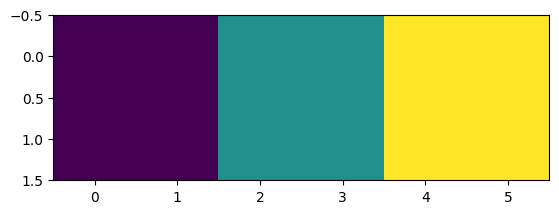

In [38]:
plt.imshow(np.array([[-1,-1,0,0,1,1],[-1,-1,0,0,1,1]]))